# IFT6135 Assignment 3
## Neural Turing Machines
### Roger Girgis, Alejandro Posada, and Matthew Scicluna

## Filling in the gaps

### Transformation Functions

We implemented the Neural Turing machine described in [1]. The goal was to better understand attention and memory augmented networks, and the difficulties encountered when training them.

The output of the controller was a $100$ dimensional vector which we transformed into parameters used in the read and write heads and attention mechanism through single layer networks with different output tranformations. We chose output transformations such that their ranges matched the constraints of the parameters as described in the paper. We note that the choice in output tranformations matched those found in most implementations of Neural turing machines. We present the choice of transformation for each parameter in the following table.

| Parameter    |Domain           | Activation                | Formula  |
|--------------|-----------------|---------------------------|----------|
| $\beta$      | $(0,\infty)$    |  Softplus                 |          |
| $\kappa$     | $\mathbb{R}^M$  |  Identity                 |          |
| $\gamma$     | $(1, \infty)$   |  1 + Softplus             |          |
| $g$          | $(0,1)$         |  Sigmoid                  |          |
| $s$          | $(0,1)^K$       |  Softmax$\circ$Softplus   |          |
| $e$          | $\mathbb{M}$    |  Sigmoid                  |          |
| $a$          | $\mathbb{M}$    |  Sigmoid                  |          |

### Diagram

(b) Present a diagram showing how you think the following are dependent on each other.

INSERT DIAGRAM HERE

* the input $x_t$
* the memory $M_{t-1}$ and $M_t$
* the output of the read head $r_{t-1}$ and $r_t$
* the erase and add vectors $e_t$ and $a_t$
* the output of the controller $o_t$

In [4]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from visualize_results import visualize_sequence
import warnings
warnings.filterwarnings('ignore')

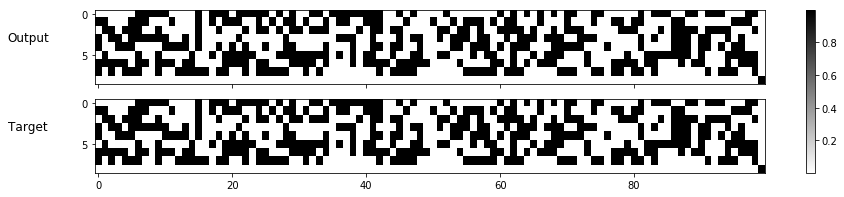

In [5]:
visualize_sequence('checkpoints/copy-batch-208.0.model', 'NTM', seq_len=100)

## References

[1] Alex Graves, Greg Wayne, and Ivo Danihelka. Neural turing machines. arXiv preprint
arXiv :1410.5401, 2014.